# Amazon Reviews 2023 Data Loading and Preprocessing

This notebook loads and preprocesses the Amazon Books dataset for Semantic ID generation in the recommendation system.

## Overview
- Load Amazon Books reviews and metadata
- Clean and filter the data
- Prepare item descriptions for Semantic ID generation
- Create user-item interaction matrix
- Save processed datasets for next phase

### 1. Import Libraries and Setup

In [36]:
import warnings
warnings.filterwarnings('ignore')
import os, gzip, json, re
from typing import Iterable, Dict, Any, Optional, List
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

REVIEWS_PATH = "data/raw/Books_reviews.jsonl.gz"
META_PATH    = "data/raw/Books_meta.jsonl.gz"

OUT_ROOT = "data/processed/books"
os.makedirs(OUT_ROOT, exist_ok=True)

ITEMS_OUT = f"{OUT_ROOT}/items.parquet"
INTER_OUT = f"{OUT_ROOT}/interactions.parquet"

In [2]:
def stream_jsonl_gz(path: str) -> Iterable[Dict[str, Any]]:
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                yield json.loads(line)
            except json.JSONDecodeError:
                continue

def scrub(s: Optional[str]) -> str:
    if not s:
        return ""
    return re.sub(r"\s+", " ", str(s)).strip()

def to_text_list(x) -> List[str]:
    if x is None:
        return []
    if isinstance(x, str):
        return [x]
    if isinstance(x, (list, tuple)):
        return [str(e) for e in x if isinstance(e, (str, int, float))]
    return []

def get_item_id(obj: Dict[str, Any]) -> Optional[str]:
    """Prefer parent_asin; fall back to asin."""
    if obj.get("parent_asin"):
        return str(obj["parent_asin"])
    if obj.get("asin"):
        return str(obj["asin"])
    return None

def unix_seconds(ts) -> Optional[int]:
    if ts is None:
        return None
    try:
        ts = int(ts)
    except Exception:
        return None
    # Convert ms → s if needed
    if ts > 10**12:
        ts //= 1000
    return int(ts)


### 2. Load and Inspect Raw Data

In [5]:
# Reviews preview
r_samp = []
for i, obj in enumerate(stream_jsonl_gz(REVIEWS_PATH)):
    r_samp.append(obj)
    if i >= 2: break

print("REVIEWS (3 rows) keys:")
for j, o in enumerate(r_samp, 1):
    print(f"\nRow {j}:")
    for k, v in o.items():
        if isinstance(v, str) and len(v) > 100:
            print(f"  {k}: {v[:100]}...")
        else:
            print(f"  {k}: {v}")

# Metadata preview
m_samp = []
for i, obj in enumerate(stream_jsonl_gz(META_PATH)):
    m_samp.append(obj)
    if i >= 2: break

print("\n\nMETA (3 rows) keys:")
for j, o in enumerate(m_samp, 1):
    print(f"\nRow {j}:")
    for k, v in o.items():
        if isinstance(v, str) and len(v) > 100:
            print(f"  {k}: {v[:100]}...")
        else:
            print(f"  {k}: {v}")


REVIEWS (3 rows) keys:

Row 1:
  rating: 1.0
  title: Not a watercolor book! Seems like copies imo.
  text: It is definitely not a watercolor book.  The paper bucked completely.  The pages honestly appear to ...
  images: [{'small_image_url': 'https://m.media-amazon.com/images/I/516HBU7LQoL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/516HBU7LQoL._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I/516HBU7LQoL._SL1600_.jpg', 'attachment_type': 'IMAGE'}, {'small_image_url': 'https://m.media-amazon.com/images/I/71+XwcacMmL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/71+XwcacMmL._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I/71+XwcacMmL._SL1600_.jpg', 'attachment_type': 'IMAGE'}, {'small_image_url': 'https://m.media-amazon.com/images/I/71RbTuvD1ZL._SL256_.jpg', 'medium_image_url': 'https://m.media-amazon.com/images/I/71RbTuvD1ZL._SL800_.jpg', 'large_image_url': 'https://m.media-amazon.com/images/I

### 3. Check Coverage and Select Join Key

In [7]:
MAX_SCAN = None  # adjust up if fast, or set to None for full scan

# collect IDs from meta (parent_asin only)
meta_parent = set()
for i, obj in enumerate(stream_jsonl_gz(META_PATH)):
    if obj.get("parent_asin"):
        meta_parent.add(str(obj["parent_asin"]))
    if MAX_SCAN and i+1 >= MAX_SCAN: break

# collect IDs from reviews (both fields)
rev_parent, rev_asin = set(), set()
for i, obj in enumerate(stream_jsonl_gz(REVIEWS_PATH)):
    if obj.get("parent_asin"):
        rev_parent.add(str(obj["parent_asin"]))
    if obj.get("asin"):
        rev_asin.add(str(obj["asin"]))
    if MAX_SCAN and i+1 >= MAX_SCAN: break

print(f"Meta parent_asin unique: {len(meta_parent):,}")
print(f"Reviews parent_asin unique: {len(rev_parent):,} | asin unique: {len(rev_asin):,}")

cov_parent = len(rev_parent & meta_parent) / max(len(rev_parent), 1)
cov_asin   = len(rev_asin & meta_parent) / max(len(rev_asin), 1)
print(f"Coverage if we use reviews parent_asin → meta parent_asin: {cov_parent:.3f}")
print(f"Coverage if we use reviews asin       → meta parent_asin: {cov_asin:.3f}")

Meta parent_asin unique: 4,448,181
Reviews parent_asin unique: 4,446,065 | asin unique: 4,493,336
Coverage if we use reviews parent_asin → meta parent_asin: 1.000
Coverage if we use reviews asin       → meta parent_asin: 0.985


### 4. Build Item Descriptions

In [9]:
def build_description(meta: Dict[str, Any]) -> str:
    """
    Build a rich description:
    - prefer 'description' if present (list or str)
    - fall back to title, subtitle, main_category, store, features, details (values),
      categories, author.name/about
    """
    parts = []

    # 1) primary description
    desc = meta.get('description', None)
    desc_list = []
    if isinstance(desc, list):
        desc_list = [scrub(d) for d in desc if scrub(d)]
    elif isinstance(desc, str):
        if scrub(desc):
            desc_list = [scrub(desc)]
    if desc_list:
        parts.append(" ".join(desc_list))

    # 2) fallbacks
    for k in ['title', 'subtitle', 'main_category', 'store']:
        s = scrub(meta.get(k))
        if s:
            parts.append(s)

    parts.extend([scrub(x) for x in to_text_list(meta.get('features')) if scrub(x)])

    det = meta.get('details')
    if isinstance(det, dict):
        parts.extend([scrub(v) for v in det.values() if scrub(v)])

    parts.extend([scrub(x) for x in to_text_list(meta.get('categories')) if scrub(x)])

    auth = meta.get('author')
    if isinstance(auth, dict):
        if auth.get('name'):
            parts.append(scrub(auth['name']))
        parts.extend([scrub(x) for x in to_text_list(auth.get('about')) if scrub(x)])

    text = " ".join([p for p in parts if p])
    if len(text) < 40 and desc_list:
        text = " ".join(desc_list)
    return text[:4000]

# Try it on 5 metadata samples to see the effect
for i, obj in enumerate(stream_jsonl_gz(META_PATH)):
    item_id = get_item_id(obj)
    if not item_id: 
        continue
    built = build_description(obj)
    print(f"\nITEM {item_id} | len={len(built)}")
    print(built[:300], "..." if len(built) > 300 else "")
    if i >= 4: break



ITEM 0701169850 | len=955
Chaucer Hardcover – Import, January 1, 2004 Books Peter Ackroyd (Author) Chatto & Windus; First Edition (January 1, 2004) English 196 pages 0701169850 978-0701169855 10.1 ounces 5.39 x 0.71 x 7.48 inches Books Literature & Fiction History & Criticism Peter Ackroyd Peter Ackroyd, (born 5 October 1949 ...

ITEM 0435088688 | len=1730
About the Author SANDRA WILDE, Ph.D., is widely recognized for her expertise in developmental spelling and her advocacy of holistic approaches to spelling and phonics. She is Professor of Curriculum and Instruction at Portland State University in Oregon. She is best known for her work in invented sp ...

ITEM 0316185361 | len=2665
Review Praise for SERVICE"An action-packed...reflective saga of contemporary military service."― Kirkus Reviews "Marcus Luttrell, with James D. Hornfischer, has written another emotional story that the reader will not want to put down."― American Thinker About the Author Marcus Luttrell became a com ...

I

In [11]:
# ====== params that i won't test ======
MIN_DESC_LEN = 80           
LAST_CHANCE_TITLE_MIN = 20  # title-only fallback length
KEEP_ONLY_NATIVE_DESC = False 

# ---------- ITEMS ----------
rows = []
seen_items = set()
n_total = n_kept = n_fallback = n_native = 0

for i, obj in enumerate(tqdm(stream_jsonl_gz(META_PATH), desc="meta→items")):
    n_total += 1
    item_id = get_item_id(obj)
    if not item_id or item_id in seen_items:
        continue

    # detect whether native description exists
    native_desc_exists = bool(obj.get('description')) and len(to_text_list(obj.get('description'))) > 0

    if KEEP_ONLY_NATIVE_DESC and not native_desc_exists:
        continue

    text = build_description(obj)  # native + fallbacks concatenated

    if len(text) < MIN_DESC_LEN:
        # last-chance: title only if long enough
        title = scrub(obj.get('title', ''))
        if len(title) >= LAST_CHANCE_TITLE_MIN:
            text = title

    if len(text) < MIN_DESC_LEN:
        continue

    desc_source = 'native' if native_desc_exists else 'fallback'
    desc_len = len(text)

    seen_items.add(item_id)
    n_kept += 1
    if desc_source == 'native': n_native += 1
    else: n_fallback += 1

    rows.append((item_id, text, desc_source, desc_len))

items_df = pd.DataFrame(rows, columns=["item_id", "description", "desc_source", "desc_len"])

print(f"\n[items] total scanned: {n_total:,} | kept: {n_kept:,}")
print(f"        native: {n_native:,} | fallback: {n_fallback:,}")
print(items_df['desc_len'].describe())
print(items_df['desc_source'].value_counts(normalize=True))

meta→items: 0it [00:00, ?it/s]


[items] total scanned: 4,448,181 | kept: 4,426,720
        native: 1,840,305 | fallback: 2,586,415
count    4.426720e+06
mean     1.884863e+03
std      1.329776e+03
min      8.000000e+01
25%      7.020000e+02
50%      1.596000e+03
75%      3.026000e+03
max      4.000000e+03
Name: desc_len, dtype: float64
desc_source
fallback    0.584273
native      0.415727
Name: proportion, dtype: float64


### 5. Build User–Item Interactions

In [13]:
# ---------- INTERACTIONS ----------
POS_THRESHOLD = 4.0         # binarize label_pos = (rating >= POS_THRESHOLD)

valid_items = set(items_df['item_id'].tolist())
rows = []
n_total = n_kept = 0

for i, obj in enumerate(tqdm(stream_jsonl_gz(REVIEWS_PATH), desc="reviews→interactions")):
    n_total += 1
    user_id = obj.get('user_id') or obj.get('reviewerID') or obj.get('customer_id')
    item_id = get_item_id(obj)
    if not user_id or not item_id:
        continue
    if item_id not in valid_items:
        continue

    ts = obj.get('timestamp') or obj.get('unixReviewTime') or obj.get('review_time') or obj.get('reviewTime')
    ts = unix_seconds(ts)
    if ts is None:
        continue

    rating = obj.get('rating') or obj.get('overall') or obj.get('star_rating')
    try:
        rating = float(rating)
    except Exception:
        continue

    label_pos = 1.0 if rating >= POS_THRESHOLD else 0.0

    rows.append((str(user_id), str(item_id), float(rating), float(label_pos), int(ts)))
    n_kept += 1

inter_df = pd.DataFrame(rows, columns=["user_id","item_id","rating","label_pos","timestamp"])

# Keep ALL rows (pos+neg). We'll filter to positives only inside the training loader for BPR.
# But dedupe to earliest per (user,item) to avoid repeated interactions biasing:
inter_df.sort_values("timestamp", inplace=True)
inter_df = inter_df.drop_duplicates(subset=["user_id","item_id"], keep="first")

print(f"\n[interactions] total scanned: {n_total:,} | kept rows: {len(inter_df):,}")
print("users:", inter_df['user_id'].nunique(), "| items:", inter_df['item_id'].nunique())
print(inter_df['label_pos'].value_counts(normalize=True))

reviews→interactions: 0it [00:00, ?it/s]


[interactions] total scanned: 29,475,453 | kept rows: 29,106,706
users: 10287207 | items: 4424610
label_pos
1.0    0.84899
0.0    0.15101
Name: proportion, dtype: float64


### 6. Quick EDA

In [39]:
print("Items:")
display(items_df.head(2))
print("\nInteractions:")
display(inter_df.head(2))

Items:


,item_id,description,desc_source,desc_len
0,0701169850,"Chaucer Hardcover – Import, January 1, 2004 Bo...",fallback,955
1,0435088688,"About the Author SANDRA WILDE, Ph.D., is widel...",native,1730



Interactions:


,user_id,item_id,rating,label_pos,timestamp
11988069,AECPR4ROUNWGRETSG3TUGIHFUQCA,0684849550,2.0,0.0,1000000079
20050093,AFIZD4DTRHHKRRKLGQBR3GYZ2L4A,0761117199,5.0,1.0,1000000167


In [40]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4426720 entries, 0 to 4426719
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   item_id      object
 1   description  object
 2   desc_source  object
 3   desc_len     int64 
dtypes: int64(1), object(3)
memory usage: 135.1+ MB


In [41]:
inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29106706 entries, 11988069 to 29286157
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   item_id    object 
 2   rating     float64
 3   label_pos  float64
 4   timestamp  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ GB


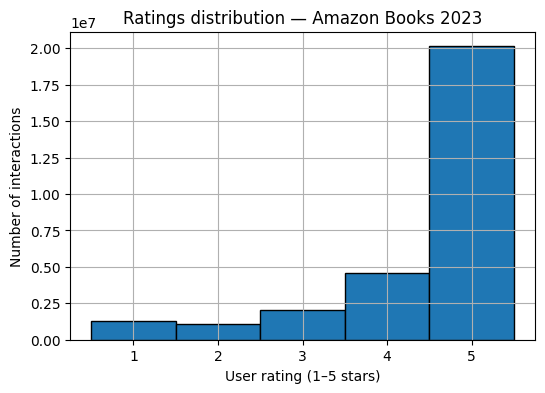

In [51]:
# ratings hist

plt.figure(figsize=(6,4))
inter_df['rating'].hist(bins=[0.5,1.5,2.5,3.5,4.5,5.5], edgecolor='black')
plt.xlabel("User rating (1–5 stars)")
plt.ylabel("Number of interactions")
plt.title("Ratings distribution — Amazon Books 2023")
plt.show()

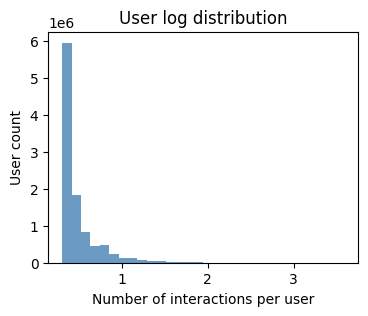

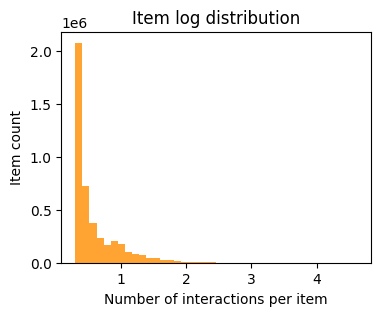

In [76]:
# User / item frequency
user_freq = inter_df['user_id'].value_counts()
item_freq = inter_df['item_id'].value_counts()

plt.figure(figsize=(4,3))
plt.hist(np.log10(user_freq + 1), bins=30, color='steelblue', alpha=0.8)
plt.xlabel("Number of interactions per user")
plt.ylabel("User count")
plt.title("User log distribution")
plt.show()

plt.figure(figsize=(4,3))
plt.hist(np.log10(item_freq + 1), bins=40, color='darkorange', alpha=0.8)
plt.xlabel("Number of interactions per item")
plt.ylabel("Item count")
plt.title("Item log distribution")
plt.show()

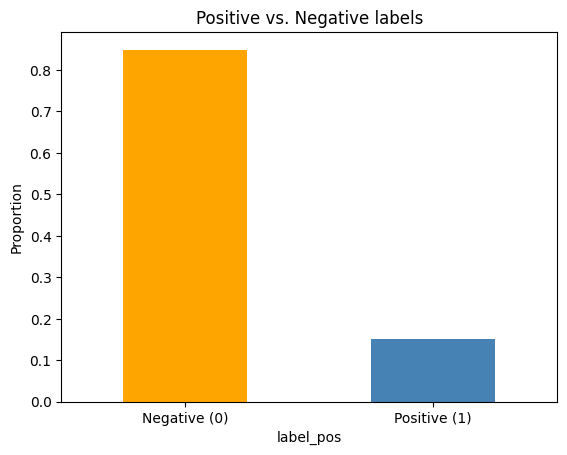

In [53]:
# Pos vs Neg labels

inter_df['label_pos'].value_counts(normalize=True).plot(kind='bar', color=['orange','steelblue'])
plt.xticks([0,1], ['Negative (0)','Positive (1)'], rotation=0)
plt.ylabel("Proportion")
plt.title("Positive vs. Negative labels")
plt.show()

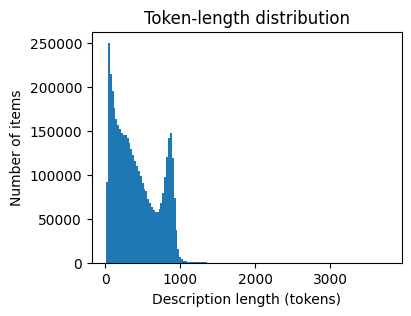

In [77]:
# Description Length: 

# 1) Tokens
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
texts = items_df["description"]  # keep as a Series
N = len(texts)
lengths = np.empty(N, dtype=np.int32)

B = 2048 
for i in tqdm(range(0, N, B), desc="Tokenizing (full)"):
    batch = texts.iloc[i:i+B].tolist()
    enc = tokenizer(
        batch,
        add_special_tokens=True,
        truncation=False,
        padding=False,
        return_length=True
    )
    if "length" in enc:  # fast tokenizers return this
        lengths[i:i+len(batch)] = np.asarray(enc["length"], dtype=np.int32)
    else:
        lengths[i:i+len(batch)] = np.asarray([len(x) for x in enc["input_ids"]], dtype=np.int32)

items_df["token_len"] = lengths  # single assign at the end

# Plot
plt.figure(figsize=(4,3))
plt.hist(lengths, bins=150)
plt.xlabel("Description length (tokens)")
plt.ylabel("Number of items")
plt.title("Token-length distribution (full dataset)")
plt.show()
# Plot
plt.figure(figsize=(4,3))
plt.hist(lengths, bins=150)
plt.xlabel("Description length (tokens)")
plt.ylabel("Number of items")
plt.title("Token-length distribution")
plt.show()

In [57]:
# Quick stats to decide truncation vs chunking
p50 = np.percentile(lengths, 50)
p90 = np.percentile(lengths, 90)
p99 = np.percentile(lengths, 99)
share_over_512 = (lengths > 512).mean()
print(f"p50={p50:.0f}, p90={p90:.0f}, p99={p99:.0f}, share>512={share_over_512:.3%}")

p50=355, p90=860, p99=960, share>512=34.610%


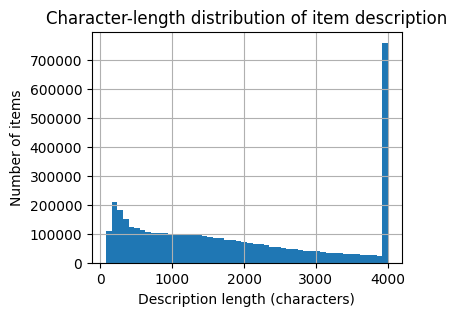

In [81]:
# 2) Characters

plt.figure(figsize=(4,3))
items_df['desc_len'].hist(bins=50)
plt.xlabel("Description length (characters)")
plt.ylabel("Number of items")
plt.title("Character-length distribution of item description")
plt.show()

In [58]:
# Summary stats

print("Users:", inter_df['user_id'].nunique())
print("Items:", inter_df['item_id'].nunique())
print("Interactions:", len(inter_df))
print("Positives (%):", round(inter_df['label_pos'].mean()*100, 2))
print("Average interactions per user:", len(inter_df)/inter_df['user_id'].nunique())
print("Average interactions per item:", len(inter_df)/inter_df['item_id'].nunique())

Users: 10287207
Items: 4424610
Interactions: 29106706
Positives (%): 84.9
Average interactions per user: 2.8294080210498342
Average interactions per item: 6.57836645489659


### 7. Save the data

In [82]:
items_df.to_parquet(ITEMS_OUT, index=False)
inter_df.to_parquet(INTER_OUT, index=False)